# Credit Card fraud detection



```
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are  - 
*  Time -  contains the seconds elapsed between each transaction and the first transaction in the dataset.
*  Amount - transaction Amount, this feature can be used for example-dependant cost-sensitive learning.
*  Class - the response variable and it takes value 1 in case of fraud and 0 otherwise.
```



## Data collection

In [1]:
!wget -q https://raw.githubusercontent.com/aspdiscovery123/Deep-Learning-for-structure-data/master/creditcard.zip
!unzip "creditcard.zip"

Archive:  creditcard.zip
  inflating: creditcard.csv          


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("creditcard.csv")
df.shape

(284807, 31)

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df.Amount.describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [7]:
# drop the time columns
# scale the amount
df.drop(columns=['Time'],inplace=True)
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler()
df['Amount'] = mm.fit_transform(df.Amount.values.reshape(-1,1))
df.shape

(284807, 30)

In [8]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.005824,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0.000105,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0.014739,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.004807,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.002724,0


In [9]:
# split into train and test
from sklearn.model_selection import train_test_split
xtrain, xtest = train_test_split(df,test_size=0.25,random_state=5)

# keeping only genuine transaction in train data
xtrain = xtrain[xtrain.Class==0]
xtrain.drop(columns=['Class'],inplace=True)

ytest = xtest['Class']
xtest.drop(columns=['Class'],inplace=True)

print(xtrain.shape,xtest.shape,ytest.shape)

(213234, 29) (71202, 29) (71202,)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Modelling the network - Autoencoder

In [10]:
from tensorflow.keras import layers,models
from tensorflow.keras import regularizers

In [11]:
ip = layers.Input(shape=(29,))

# encoder section
en = layers.Dense(18,activation='tanh',activity_regularizer=regularizers.l1(1e-5))(ip)
en = layers.Dense(12,activation='relu')(en)

# Decoder section
de = layers.Dense(12,activation='relu')(en)
de = layers.Dense(18,activation='tanh',activity_regularizer=regularizers.l1(1e-5))(de)

# outputlayer
op = layers.Dense(29)(de)

autoencoder = models.Model(inputs=ip,outputs=op)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense (Dense)                (None, 18)                540       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                228       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 18)                234       
_________________________________________________________________
dense_4 (Dense)              (None, 29)                551       
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
___________________________________________________________

In [12]:
autoencoder.compile(optimizer='adam',loss='mse')
autoencoder.fit(xtrain,xtrain,epochs=50,batch_size=64,validation_data=(xtest,xtest))

Epoch 1/50
3332/3332 [==============================] - 8s 2ms/step - loss: 0.4683 - val_loss: 0.3770
Epoch 2/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.3029 - val_loss: 0.3141
Epoch 3/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2589 - val_loss: 0.2790
Epoch 4/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2382 - val_loss: 0.2673
Epoch 5/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2285 - val_loss: 0.2567
Epoch 6/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2223 - val_loss: 0.2513
Epoch 7/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2177 - val_loss: 0.2448
Epoch 8/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2139 - val_loss: 0.2442
Epoch 9/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.2110 - val_loss: 0.2404
Epoch 10/50
3332/3332 [==============================] - 7s 2ms/step - loss: 0.207

In [13]:
preds = autoencoder.predict(xtest)

In [14]:
preds.shape,xtest.values.shape

((71202, 29), (71202, 29))

In [15]:
rec_error = np.mean(np.power(np.array(xtest.values) - preds,2),axis=1)
error_df = pd.DataFrame({'Reconstruction_error':rec_error,'true_class':ytest})
error_df.head()

,Reconstruction_error,true_class
27733,0.200207,0
58505,0.169087,0
231716,0.183442,0
123042,0.038343,0
215839,0.105317,0


### Reconstruction error without fraud

(array([7.1054e+04, 1.8000e+01, 6.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([4.23323345e-03, 1.62136385e+01, 3.24230438e+01, 4.86324492e+01,
        6.48418545e+01, 8.10512598e+01, 9.72606651e+01, 1.13470070e+02,
        1.29679476e+02, 1.45888881e+02, 1.62098286e+02]),
 <a list of 10 Patch objects>)

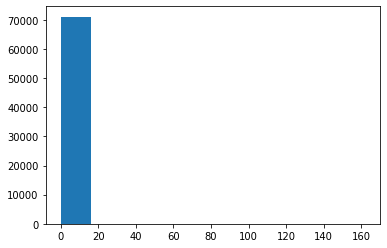

In [16]:
normal_df = error_df[error_df.true_class==0]
plt.hist(normal_df.Reconstruction_error.values)

### Reconstruction error with fraud

(array([78., 14.,  5., 15.,  5.,  2.,  1.,  0.,  0.,  1.]),
 array([2.34320683e-02, 1.76487977e+01, 3.52741633e+01, 5.28995289e+01,
        7.05248945e+01, 8.81502601e+01, 1.05775626e+02, 1.23400991e+02,
        1.41026357e+02, 1.58651722e+02, 1.76277088e+02]),
 <a list of 10 Patch objects>)

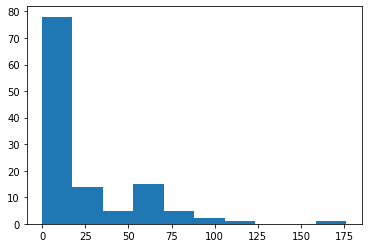

In [17]:
fraud_df = error_df[error_df.true_class==1]
plt.hist(fraud_df.Reconstruction_error.values)

In [18]:
fraud_df.shape

(121, 2)

In [20]:
normal_df.describe()

,Reconstruction_error,true_class
count,71081.000000,71081.0
mean,0.145527,0.0
std,0.929908,0.0
min,0.004233,0.0
25%,0.045918,0.0
50%,0.073878,0.0
75%,0.125609,0.0
max,162.098286,0.0


In [21]:
fraud_df.describe()

,Reconstruction_error,true_class
count,121.000000,121.0
mean,23.184940,1.0
std,30.043560,0.0
min,0.023432,1.0
25%,4.658795,1.0
50%,8.644258,1.0
75%,26.739555,1.0
max,176.277088,1.0


In [27]:
normal_df.Reconstruction_error.sort_values(ascending=False).head(250)

39769     162.098286
44254      55.838727
227921     55.070149
12922      46.170989
12325      45.560943
             ...    
64580       2.722147
73072       2.710245
188476      2.689119
187276      2.671388
105026      2.670184
Name: Reconstruction_error, Length: 250, dtype: float64

In [29]:
from sklearn import metrics
import seaborn as sns

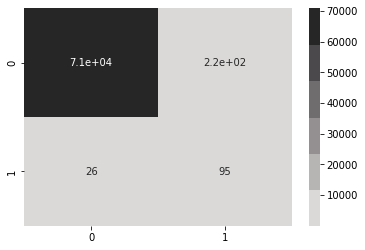

In [32]:
ypred = [1 if error>3 else 0 for error in error_df.Reconstruction_error.values]
cm = metrics.confusion_matrix(ytest,ypred)
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,cmap=sns.cubehelix_palette(hue=0.05))
plt.show()